In [1]:
import glob
import os
import shutil
import multiprocessing
import cv2
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_pre
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import normalized_mutual_info_score, silhouette_score
# from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from bhtsne import tsne
# from pyclustering.cluster.cure import cure
# import seaborn as sns
%matplotlib inline

## Global

### Variables

In [4]:
SAMPLE_DIR = "data/traffic-small"
FINAL_DIR = "data/traffic"
dataset_dir = FINAL_DIR

# Sort is the key :/
dataset = sorted(glob.glob(dataset_dir + "/*.jpg"))

# Where we store the predictions
RESULT_DIR = "res"
# Where we store the extracted features
feature_saved_dir = "extracted_features"

pretrain_input_size = (54, 28)

n_clusters = 14

cpus = multiprocessing.cpu_count()

### Utils

In [5]:
def load_data_as_lines(path):
    r""" Open text file by path and read all lines """
    with open(path, "r") as fh:
        lines = fh.readlines()
        
    # transform docs into lists of words
    raw_lines = [l.split() for l in lines]

    return raw_lines

def save_result_as_file(prediction, file_name="prediction.dat"):
    r""" Save the predicted result as a new file """
    file_content = "\n".join(list(map(str, prediction)))
    path = os.path.join(RESULT_DIR, file_name)
    with open(path, "w") as fd:
        fd.write(file_content) 

In [6]:
def save_formatted_name(prediction, model, net="res50", pca=False, random_id=None):
    fname = "%s_%s_%s%s%s.dat" % (
        model.__class__.__name__,
        net,
        "%sx%s" % pretrain_input_size,
        "_pca" if pca else "",
        "_rand%s" % random_id if random_id else ""
    )
    save_result_as_file(prediction, fname)
    print("Saved %s" % fname)

In [7]:
def shuffle(x):
    np.take(x, np.random.permutation(x.shape[0]), axis=0, out=x)

## Analytics
Analyze the data distribution first, so we can decide how to resize the image

In [233]:
dim_to_key = lambda dim: "({},{})={}".format(dim[0], dim[1], dim[0] * dim[1])

In [234]:
cnt = Counter()
cnt2 = Counter()

images = []
for path in dataset:
    img = cv2.imread(path)
    key = dim_to_key(img.shape)
    cnt[key] += 1
    cnt2[img.shape[0] * img.shape[1]] += 1

In [235]:
cnt.most_common()

[('(61,35)=2135', 477),
 ('(61,33)=2013', 349),
 ('(44,24)=1056', 304),
 ('(57,27)=1539', 300),
 ('(65,33)=2145', 295),
 ('(67,32)=2144', 286),
 ('(62,29)=1798', 268),
 ('(57,29)=1653', 263),
 ('(56,33)=1848', 262),
 ('(72,40)=2880', 258),
 ('(62,39)=2418', 257),
 ('(55,32)=1760', 252),
 ('(54,23)=1242', 251),
 ('(49,22)=1078', 234),
 ('(60,36)=2160', 227),
 ('(52,25)=1300', 224),
 ('(52,27)=1404', 220),
 ('(55,26)=1430', 214),
 ('(57,28)=1596', 213),
 ('(46,27)=1242', 211),
 ('(81,42)=3402', 210),
 ('(63,32)=2016', 207),
 ('(53,32)=1696', 205),
 ('(56,24)=1344', 205),
 ('(71,38)=2698', 204),
 ('(70,32)=2240', 200),
 ('(46,24)=1104', 198),
 ('(62,34)=2108', 196),
 ('(59,34)=2006', 195),
 ('(77,146)=11242', 194),
 ('(63,34)=2142', 192),
 ('(72,38)=2736', 190),
 ('(97,38)=3686', 186),
 ('(64,35)=2240', 185),
 ('(59,32)=1888', 185),
 ('(59,26)=1534', 185),
 ('(53,24)=1272', 184),
 ('(63,28)=1764', 183),
 ('(54,24)=1296', 181),
 ('(54,26)=1404', 178),
 ('(47,21)=987', 175),
 ('(57,26)=1482

In [236]:
cnt2.most_common()

[(2135, 481),
 (1242, 462),
 (2240, 406),
 (1404, 398),
 (2145, 393),
 (2013, 350),
 (1056, 337),
 (2880, 328),
 (1798, 328),
 (1300, 324),
 (1344, 309),
 (1539, 301),
 (1104, 291),
 (2144, 286),
 (2016, 280),
 (1508, 275),
 (1144, 275),
 (1620, 271),
 (1848, 269),
 (1653, 263),
 (2418, 261),
 (2160, 257),
 (1760, 257),
 (1624, 254),
 (1512, 234),
 (1078, 234),
 (1296, 230),
 (2736, 222),
 (1596, 219),
 (1176, 219),
 (2100, 219),
 (2108, 216),
 (1430, 216),
 (3402, 215),
 (1456, 215),
 (1400, 214),
 (1200, 211),
 (880, 208),
 (1696, 206),
 (11242, 205),
 (2698, 205),
 (1680, 203),
 (1860, 199),
 (2006, 195),
 (1674, 195),
 (2142, 193),
 (2112, 193),
 (1764, 192),
 (3686, 186),
 (1888, 185),
 (1534, 185),
 (1272, 184),
 (1008, 182),
 (1012, 182),
 (987, 175),
 (1482, 175),
 (4356, 174),
 (1377, 172),
 (1288, 171),
 (1782, 170),
 (1829, 170),
 (1276, 170),
 (1767, 169),
 (1710, 165),
 (1650, 163),
 (1856, 157),
 (1431, 156),
 (1372, 156),
 (1127, 155),
 (945, 154),
 (1568, 154),
 (1922, 

## Preprocessing

### Object Detection

In [6]:
options = {
    'config': os.path.join(DARKFLOW_DIR, "cfg"),
    'model': os.path.join(DARKFLOW_DIR, "cfg", "yolo.cfg"),
    'load': os.path.join(DARKFLOW_DIR, "bin", "yolov2.weights"),
    'threshold': 0.5
}
tfnet = TFNet(options)

/WAVE/users/unix/tchiang/PR3/../darkflow/darkflow/dark/darknet.py:54: UserWarning: /WAVE/users/unix/tchiang/PR3/../darkflow/cfg/yolov2.cfg not found, use /WAVE/users/unix/tchiang/PR3/../darkflow/cfg/yolo.cfg instead
  cfg_path, FLAGS.model))


Parsing /WAVE/users/unix/tchiang/PR3/../darkflow/cfg/yolo.cfg
Loading /WAVE/users/unix/tchiang/PR3/../darkflow/bin/yolov2.weights ...
Successfully identified 203934260 bytes
Finished in 0.10474467277526855s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 

### Image Preprocess

In [9]:
images = []
for path in dataset:
    img = image.load_img(path, target_size=pretrain_input_size)
    img = image.img_to_array(img)
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, pretrain_input_size)
#     img = img / 255.0  # Normalization
    images.append(img)

In [10]:
train_input = np.array(images)

In [11]:
train_input.shape

(100000, 54, 28, 3)

## Feature Extraction 

In [12]:
def init_feature_saved_dir():
    if not os.path.exists(feature_saved_dir) or \
        len(os.listdir(feature_saved_dir)) == 0:
        try:
            shutil.rmtree(feature_saved_dir)
        except:
            pass

        os.mkdir(feature_saved_dir)

In [13]:
supported_models = ["vgg", "resnet50"]

def save_batch_features(x,
                        model_name="vgg",
                        pre=False,
                        pooling=None,
                        save=True,
                        filename=None):
    assert(model_name in supported_models)
    
    init_feature_saved_dir()
    input_dim = pretrain_input_size + (3,)
    
    if model_name == "vgg":
        if pre:
            x = vgg16_pre(x)
        model = VGG16(weights='imagenet',
                      include_top=False,
                      pooling=pooling)
        
    elif model_name == "resnet50":
        if pre:
            x = resnet50_pre(x)
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         pooling=pooling)

    y = model.predict(x,
                      workers=cpus,
                      use_multiprocessing=True)
    
    print(y.shape)

    if save or filename:
        name = filename if filename \
            else "features-%s_%s%s%s%s" % (
                model_name,
                "%sx%s" % pretrain_input_size,
                "_%s" % pooling if pooling else "",
                "_%s" % "preprocess" if pre else "",
                "_final" if dataset_dir == FINAL_DIR else "_sample",
            )
        np.save("%s/%s" % (
            feature_saved_dir, 
            name
        ), y)
        print("Saved as %s", name)
    return y

In [14]:
# features_vgg = save_batch_features(train_input)

In [15]:
features_resnet50 = save_batch_features(train_input, "resnet50")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(100000, 2, 1, 2048)
Saved as %s features-resnet50_54x28_final


## Preprocess

### Load data (optional)

In [8]:
# Load extracted features locally
# x = features_resnet50

# Load final for processing
x = np.load(os.path.join(feature_saved_dir, "features-resnet50_54x28_final_7.npy"))

# Load best random sample so far to evaluate metrics
# x = np.load(os.path.join(feature_saved_dir, "resnet50_54x28_pca_s.npy"))

In [9]:
x.shape

(100000, 2, 1, 2048)

### Flatten

In [10]:
def flatten(x):
    return np.array([np.ndarray.flatten(img) for img in x])

In [11]:
x_flatten = flatten(x)

In [12]:
x_flatten.shape

(100000, 4096)

## Dimensionality Reduction

### TSNE

In [18]:
def get_tsne_data(x_train):
    n_components = 3482

    print("Original: %d. After PCA: %d" % (x_train.shape[-1], n_components))

#     tsne = TSNE(n_components=n_components, verbose=1, method="exact",
#                 perplexity=40, n_iter=300, n_jobs=cpus)
#     return tsne.fit_transform(x_train)

    return tsne(x_train.astype('float64'), dimensions=n_components, perplexity=50)


In [ ]:
x_flatten_, _ = get_tsne_data(x_flatten)

Original: 4096. After PCA: 2400


In [11]:
np.save("%s/%s" % (
    feature_saved_dir, 
    "resnet50_%sx%s_tsne2400" % pretrain_input_size
), x_flatten_)

### PCA

In [14]:
def get_pca_data(x_train, do_the_math=True):
    def percvar(v):
        r"""Transform eigen/singular values into percents.
        Return: vector of percents, prefix vector of percents
        """
        # sort values
        s = np.sort(np.abs(v))
        # reverse sorting order
        s = s[::-1]
        # normalize
        s = s/np.sum(s)
        return s, np.cumsum(s)

    def perck(s, p):
        return next(i + 1 for i, v in enumerate(s) if v >= p)

    if do_the_math:
        X_std = StandardScaler().fit_transform(x_train)
        means = np.mean(X_std, axis=0)
        X_sm = X_std - means

        U,s,V = np.linalg.svd(X_sm)
        _, pv = percvar(s**2/(X_sm.shape[0]-1))

        percentage_explained = 99
        n_components = perck(pv, percentage_explained * 0.01)
    else:
        n_components = 2400
    
    print("Original: %d. After PCA: %d" % (x_train.shape[-1], n_components))

    svd = TruncatedSVD(n_components=n_components)
    svd.fit(x_train)

    return svd.transform(x_train), svd

In [15]:
x_flatten_, _ = get_pca_data(x_flatten)

Original: 4096. After PCA: 3482


In [25]:
np.save("%s/%s" % (
    feature_saved_dir, 
    "resnet50_%sx%s_pca2371_sample" % pretrain_input_size
), x_flatten_)

In [16]:
np.save("%s/%s" % (
    feature_saved_dir, 
    "resnet50_%sx%s_pca23xx_final_sort" % pretrain_input_size
), x_flatten_)

In [17]:
# Load the full post-PCA dataset 
x_flatten_ = np.load(os.path.join(feature_saved_dir, "resnet50_54x28_pca3482_final.npy"))

In [189]:
x_flatten__ = TruncatedSVD(n_components=2376).fit_transform(x_flatten_)

## Clustering

In [17]:
def generate_random_test_file(x, pca=False):
    r"""Let's not waste submissions and hope it's not too bad"""
    shuffle(x)
    random_state = np.random.randint(0, len(x) - 1)
    model = KMeans(n_clusters=n_clusters,
                   n_jobs=cpus,
                   random_state=random_state)
    model.fit(x)
    prediction = model.labels_.tolist()
    save_formatted_name(prediction, model, pca=pca, random_id=random_state)

In [198]:
generate_random_test_file(x_flatten_, pca=True)
generate_random_test_file(x_flatten_, pca=True)
# generate_random_test_file(x_flatten)
# generate_random_test_file(x_flatten)
# generate_random_test_file(x_flatten)

Saved KMeans_res50_54x28_pca_rand2719.dat
Saved KMeans_res50_54x28_pca_rand4336.dat


In [27]:
y = load_data_as_lines(os.path.join(dataset_dir, "clusters.txt"))
# y = load_data_as_lines("KMeans_res50_54x28_pre.dat")
y = np.array(y).flatten()
y = y.astype(int)

In [18]:
model = SpectralClustering(n_clusters=n_clusters, random_state=4,
                           n_init=50, n_neighbors=10,
                          affinity="nearest_neighbors", n_jobs=cpus)

In [ ]:
model.fit(x_flatten)

/WAVE/users/unix/tchiang/.local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
prediction = model.labels_
np.unique(prediction, return_counts=True)

In [39]:
normalized_mutual_info_score(y, prediction)

0.4648873840700354

In [ ]:
######## I"M HERE ########## wait for no PCA ver

In [ ]:
save_formatted_name(prediction, model, pca=False)

In [ ]:
######## I"M HERE ##########

In [27]:
prediction886 = prediction

In [43]:
cure_instance2 = cure(x_flatten, 14,
                      number_represent_points=40,
                      compression=0.05);

In [ ]:
cure_instance2.process();

In [ ]:
clusters = cure_instance2.get_clusters();

In [ ]:
sample_size = 4209
pred = [False for _ in range(sample_size)]

label = 0
for cluster in clusters:
    label += 1
    for i in cluster:
        pred[i] = label

In [ ]:
normalized_mutual_info_score(y, pred)

In [ ]:
np.unique(pred, return_counts=True)

In [145]:
np.unique(y, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([1286,  602,  128,   26,   10,   27,    7,  105,    9,   12,   11,
         470,   42, 1474]))

In [56]:
cure_instance = cure(x_flatten, 14);

In [57]:
cure_instance.process();

In [141]:
clusters = cure_instance.get_clusters();

In [142]:
sample_size = 4209
pred = [False for _ in range(sample_size)]

label = 0
for cluster in clusters:
    label += 1
    for i in cluster:
        pred[i] = label

In [128]:
list(filter(lambda x: x > 1, pred))

[4, 7, 11, 12, 3, 8, 13, 2, 14, 9, 6, 5, 10]

In [60]:
np.unique(clusters, return_counts=True)

(array([list([380]), list([1118]), list([1187]), list([1218]),
        list([1414]), list([1542]), list([1596]), list([1812]),
        list([2170]),
        list([2252, 2289, 2288, 3863, 868, 2459, 476, 3154, 1995, 912, 2880, 3029, 3965, 2883, 1597, 3800, 1849, 616, 3182, 873, 4171, 3183, 1030, 1356, 1975, 181, 1864, 3224, 3773, 760, 2884, 341, 2665, 3471, 342, 3804, 2095, 91, 782, 1558, 2452, 14, 1114, 340, 205, 1489, 237, 3158, 1980, 2576, 952, 206, 1073, 3361, 1110, 2311, 2450, 1144, 108, 1593, 1594, 1592, 4046, 1936, 881, 3276, 4112, 2674, 3420, 2514, 911, 1606, 1310, 3659, 1035, 748, 732, 1028, 2182, 3223, 581, 1840, 2895, 413, 761, 4140, 2782, 1056, 3075, 1349, 195, 2355, 1930, 4045, 3113, 3407, 1481, 2380, 2627, 762, 2420, 3687, 643, 4185, 1172, 3131, 2229, 1189, 2109, 1052, 1260, 3865, 809, 467, 1360, 1687, 2833, 807, 1643, 2983, 4136, 350, 1088, 3036, 3435, 3456, 2856, 606, 1170, 3544, 385, 854, 1763, 3405, 3436, 716, 1004, 2139, 2267, 964, 4076, 3173, 2966, 661, 1676, 2499, 9

In [110]:
lii = [14 for i in range(4209-13)] + [10,11,12,13] + [1,2,3,4,5,6,7,8,9]

In [92]:
len([14 for i in range(4209-13)]) + 13

4209

In [89]:
model4 = OPTICS(min_samples=20, n_jobs=cpus)

In [90]:
model4.fit(x_flatten)

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=None, min_samples=20, n_jobs=96, p=2,
       predecessor_correction=True, xi=0.05)

In [91]:
prediction = model4.labels_.tolist()

In [92]:
np.unique(prediction, return_counts=True)

(array([0]), array([4209]))

In [93]:
normalized_mutual_info_score(y, pred)

NameError: name 'pred' is not defined

In [51]:
bad_y = y

In [ ]:
save_result_as_file(bad_y, "bad_labels_0.09")

In [53]:
shuffle(x_flatten_)

In [13]:
shuffle(x_flatten)

In [28]:
model = KMeans(n_clusters=n_clusters, n_jobs=cpus, random_state=np.random.randint(0, 100000))

In [29]:
model.fit(x_flatten_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=96, precompute_distances='auto',
       random_state=44919, tol=0.0001, verbose=0)

In [31]:
prediction = model.labels_.tolist()
np.unique(prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([222, 395, 193, 155, 395, 154, 611, 339, 386, 346, 298, 140, 400,
        175]))

In [32]:
normalized_mutual_info_score(y, prediction)

0.34634710626224785

In [17]:
save_formatted_name(prediction, model, pca=True)

Saved


In [60]:
np.unique(prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([15762,  6096,  3459,  7189,  2782,  6835,  9277,  6840,  4040,
        10503,  4544,  8670,  5181,  8822]))

In [17]:
np.unique(prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([174, 265, 147, 139, 371, 555, 713, 258, 595, 306, 149, 198, 149,
        190]))

In [21]:
np.unique(y, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([1286,  602,  128,   26,   10,   27,    7,  105,    9,   12,   11,
         470,   42, 1474]))

In [36]:
# Load keras. NO /255. No pre 54x32
normalized_mutual_info_score(prediction_bad, prediction)

0.008752721592803447

In [27]:
# Load keras. NO /255. No pre 54x32
normalized_mutual_info_score(y, prediction)

0.009764202094465999

In [33]:
np.unique(prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 6131, 15850,  3450,  2940,  6855, 12499,  4526,  8133,  7220,
         5164,  7146,  6948,  3659,  9479]))

In [25]:
np.unique(prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 6093,  2682, 15738,  9199,  8636,  6886,  7138,  3480, 10513,
         4282,  8835,  6769,  4539,  5210]))

In [27]:
silhouette_score(x_flatten, prediction)

0.06024034

In [197]:
# Load keras. NO /255. No pre 52x28
normalized_mutual_info_score(y, prediction)

0.34911245151680814

In [165]:
# Load keras. NO /255. No pre 55x28
normalized_mutual_info_score(y, prediction)

0.3369083209992603

In [140]:
# Load keras. NO /255. No pre 56x28. Random2
normalized_mutual_info_score(y, prediction)

0.3301861533987485

In [134]:
# Load keras. NO /255. No pre 56x28
normalized_mutual_info_score(y, prediction)

0.3397261616409601

In [116]:
# Load keras. NO /255 . No PRE
normalized_mutual_info_score(y, prediction)

0.36985722497762685

In [104]:
# Load keras. NO /255. Pre
normalized_mutual_info_score(y, prediction)

0.3549871534758922

In [91]:
# Load keras. /255. Pre
normalized_mutual_info_score(y, prediction)

0.1599681874732601

In [48]:
# Load CV2. /255. Pre
normalized_mutual_info_score(y, prediction)

0.1454800639175132

In [50]:
save_formatted_name(prediction, model, pca=True)

Saved


In [40]:
model.fit(x_flatten_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=80, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [41]:
prediction2 = list(map(lambda x: x, model.labels_.tolist())) # starts from 1

In [42]:
np.unique(prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([604, 175, 258, 713, 206, 257, 143, 166, 146, 576, 203, 123, 298,
        341]))

In [43]:
normalized_mutual_info_score(y, prediction2)

0.36736932637929987

In [121]:
model2 = DBSCAN(eps=49.8, min_samples=3, n_jobs=cpus)
model2.fit(x_flatten)
print("Unique labels:", len(np.unique(model2.labels_)))

prediction2 = list(map(lambda x: x, model2.labels_.tolist())) # starts from 1
normalized_mutual_info_score(y, prediction2)

DBSCAN(algorithm='auto', eps=49.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=80, p=None)

In [41]:
model3 = AgglomerativeClustering(n_clusters=n_clusters, memory="tmp",
                                 affinity="cosine", linkage="average")

In [42]:
model3.fit(x_flatten)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory='tmp', n_clusters=14)

In [43]:
prediction3 = model3.labels_.tolist()
np.unique(prediction3, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([2422, 1726,   14,    5,   19,    4,   12,    1,    1,    1,    1,
           1,    1,    1]))

In [26]:
save_formatted_name(prediction3, model3, pca=False)

Saved AgglomerativeClustering_res50_54x28.dat


In [44]:
normalized_mutual_info_score(y, prediction3) # com + cosine

0.356493096299805

In [176]:
model3.predict(x_flatten_)

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

In [178]:
from sklearn.svm import LinearSVC

In [187]:
mm = LinearSVC().fit(x_flatten, prediction3)

In [191]:
pred = mm.predict(x_flatten__)

In [193]:
np.unique(pred, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([10797, 40129, 46047,   124,  1697,   519,    16,   140,     8,
           10,    40,   230,   187,    56]))

In [194]:
save_formatted_name(pred, model3, pca=False)

Saved


In [154]:
normalized_mutual_info_score(y, prediction3) # ward + eu

0.38448107898748035

In [146]:
normalized_mutual_info_score(y, prediction3) # avg + cosine

0.4331011426776429

In [134]:
normalized_mutual_info_score(y, prediction3) # com + cosine

0.36958888818960556

In [109]:
normalized_mutual_info_score(y, prediction3) # com + eu

0.2762725094445813

In [105]:
normalized_mutual_info_score(y, prediction3) # single + eu

0.004855452402249454

In [101]:
normalized_mutual_info_score(y, prediction3) # avg + euclidean

0.008380890797888394

0.3576940779415291

In [201]:
# 52x28. NO PCA
normalized_mutual_info_score(y, prediction3)

0.36657688044484626

In [149]:
# PCA
normalized_mutual_info_score(y, prediction3)

0.3715073619917504

In [145]:
# 56x28. No pre. No PCA
normalized_mutual_info_score(y, prediction3)

0.3802264545757315

In [ ]:
save_formatted_name(prediction3, model3, pca=False)

In [177]:
##### Dim (54, 28)
# RESNET50 + AgglomerativeClustering(elu, ward) 0.3769453717166426
# RESNET50_PCA + AgglomerativeClustering(elu, ward) 0.3844810789874803
# RESNET50_PCA + AgglomerativeClustering(cosine, complete) 0.36958888818960556

# RESNET50 + KMEANS 0.36985722497762685
# RESNET50_PCA + KMEANS 0.28

# RESNET50 + DBSCAN(49.8, 3) 0.02377917875872419

##### Bad dimensions (64, 64)
# VGG16_MAX + KMEANS 0.008307981394281364
# VGG16_MAX_PCA + KMEANS 0.009747882300356864
# VGG16 + KMEANS 0.009683774163696106
# VGG16_PCA + KMEANS 0.010623286038995799
# RESNET50 + KMEANS 0.009794626073636827
# RESNET50_PCA + KMEANS 0.008068110910338717
# RESNET50_MAX + KMEANS 0.01032285854898277
# RESNET50_MAX_PCA + KMEANS 0.008569389462865706

# VGG16 + DBSCAN(0.5, 5) 0.024794674645757197

In [ ]:
save_result_as_file(prediction, "kmeans_res50_pca.dat")

## Visualize the result

In [30]:
svd = TruncatedSVD(n_components=2)
x_pca = svd.fit_transform(x_flatten_)
# x_pca = svd.fit_transform(flatten(train_input))



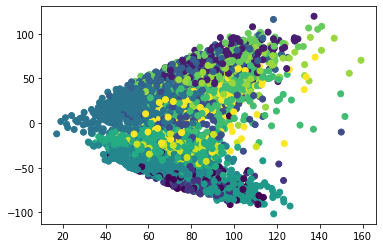

In [44]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=prediction2)
plt.show()